In [56]:
import pickle
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
import json
import pandas as pd
import numpy as np
import os
import glob
import os.path
import chart_studio.plotly as py
import plotly.graph_objs as go
from itertools import product
from plotly.subplots import make_subplots
import  plotly.graph_objs as go 
import plotly
from itertools import product
import h5py
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform


In [2]:
# Paths to all pkl files 
naive_stillff_path = '/Users/huseyinelmas/Desktop/CCN-Lab/CCN-RSA/RSA_Results/Naive/Still_FF/correlation_hamming_avg_subjects_results.pkl'
naive_stillmf_path = '/Users/huseyinelmas/Desktop/CCN-Lab/CCN-RSA/RSA_Results/Naive/Still_MF/correlation_hamming_avg_subjects_results.pkl'
naive_video_path   = '/Users/huseyinelmas/Desktop/CCN-Lab/CCN-RSA/RSA_Results/Naive/Video/correlation_hamming_avg_subjects_results.pkl'
prior_still_path   = '/Users/huseyinelmas/Desktop/CCN-Lab/CCN-RSA/RSA_Results/Prior/Still/correlation_hamming_avg_subjects_results.pkl'
prior_video_path   = '/Users/huseyinelmas/Desktop/CCN-Lab/CCN-RSA/RSA_Results/Prior/Video/correlation_hamming_avg_subjects_results.pkl'


In [3]:
# Load pickle files as dataframes eeg, rdm distance metrics
n_sff_rdm_statistics_df, eeg_rdm_dist_metric, model_rdm_dist_metric = pd.read_pickle(naive_stillff_path)
n_smf_rdm_statistics_df, eeg_rdm_dist_metric, model_rdm_dist_metric = pd.read_pickle(naive_stillmf_path)
n_v_rdm_statistics_df, eeg_rdm_dist_metric, model_rdm_dist_metric = pd.read_pickle(naive_video_path)
p_s_rdm_statistics_df, eeg_rdm_dist_metric, model_rdm_dist_metric = pd.read_pickle(prior_still_path)
p_v_rdm_statistics_df, eeg_rdm_dist_metric, model_rdm_dist_metric = pd.read_pickle(prior_video_path)

In [4]:
# Merge all dfs in one df
frames = [n_sff_rdm_statistics_df, n_v_rdm_statistics_df, p_s_rdm_statistics_df,p_v_rdm_statistics_df]
rdm_df = pd.concat(frames)

In [95]:
def find_significant_rdms(df, alpha=0.001,correct=True):
    pos_corr_rdms =  df[df.kendall_tau > 0]
    n_test = 1
    if correct:
        n_test = 400
    significant_rdms = pos_corr_rdms[pos_corr_rdms["kendall_p-value"]/2 <= (alpha/n_test)]
    return significant_rdms

In [13]:
def plot_experiment_stimuli_comparisons(rdm_df,electrode_region, model_name):
    fig = make_subplots(rows=2, cols=2,shared_yaxes=False,
    subplot_titles=("Naive: Still vs Video", "Prior: Still vs Video", 
                    "Still: Naive vs Prior", "Video: Naive vs Prior"))
    colors = px.colors.qualitative.Plotly 
    
    variables = ['still', 'video']
    constants = ['naive', 'prior']
    conditions = ["naive still", "naive video", "prior still", "prior video"]
    c_no = 0
    
    # Plots for Naive still vs Naive video, Prior still vs Prior video 
    for col_no, constant in enumerate(constants):
        for variable in variables:
            df_to_plot = rdm_df[(rdm_df["model_name"] == model_name) 
                                & (rdm_df["electrode_region"] == electrode_region)
                                & (rdm_df["experiment_type"] == constant) 
                                & (rdm_df["stimulus_type"] == variable)]
            pos_corr = find_significant_rdms(df_to_plot)["time"].tolist()           
            # Plots the kendall tau curve
            fig.add_trace(go.Scatter(x=df_to_plot["time"],
                                    y=df_to_plot["kendall_tau"],
                                    legendgroup=constant + " " + variable,
                                    mode='lines',
                                    name=constant + " " + variable,
                                    line_color = colors[conditions.index(constant + " " + variable)]),
                                    row=1, col=col_no+1)
            
            # Plotting the significance points in below the curves
            fig.add_trace(go.Scatter(
                            mode='markers',
                            legendgroup=constant + " " + variable,
                            name=constant + " " + variable,
                            x=pos_corr,
                            y=[-.1-(c_no*.02) for _ in range(len(pos_corr))],
                            marker=dict( size=2,color= colors[conditions.index(constant + " " + variable)]),
                            showlegend=False),row = 1, col=col_no+1)
            
            fig.update_yaxes(range=[-0.2, 0.6])
            fig.update_yaxes(title_text="Kendall-tau", row=1, col=col_no+1)
            fig.update_xaxes(title_text="Time ms (relative to stimulus onset)",  row=1, col=col_no+1)
            c_no = c_no+1

     # Plots for Prior Still vs Naive Still, Naive video vs Prior video 
    constants = ['still', 'video']
    variables = ['naive','prior']
    c_no = 0
    for col_no, constant in enumerate(constants):
        for  variable in variables:
            
            df_to_plot = rdm_df[(rdm_df["model_name"] == model_name) 
                                & (rdm_df["electrode_region"] == electrode_region)
                                & (rdm_df["experiment_type"] == variable) 
                                & (rdm_df["stimulus_type"] == constant)]
            pos_corr = find_significant_rdms(df_to_plot)["time"].tolist()   
            # Plotting the kendall tau curve
            fig.add_trace(go.Scatter(x=df_to_plot["time"],
                                    y=df_to_plot["kendall_tau"],
                                    mode='lines',
                                    legendgroup=variable + " " + constant,
                                    name= variable + " " + constant,
                                    line_color = colors[conditions.index(variable + " " + constant)]),
                                    row=2, col=col_no+1)
            
            # Significance dots plotting
            fig.add_trace(go.Scatter(mode='markers',
                            legendgroup=variable + " " + constant,
                            name=variable + " " + constant,
                            x=pos_corr,
                            y=[-.1-(c_no*.02) for _ in range(len(pos_corr))],
                            marker=dict(size=2,color= colors[conditions.index(variable + " " + constant)]),
                            showlegend=False),row = 2, col=col_no+1)
            fig.update_yaxes(range=[-0.2, 0.6])
            fig.update_yaxes(title_text="Kendall-tau", row=1, col=col_no+1)
            c_no = c_no+1
    fig.update_layout(height=1000, width=1700,title=electrode_region + " " + model_name,
    xaxis_title="Time ms (relative to stimulus onset)",
    yaxis_title="Kendall-tau",
    font=dict(size=18,color="#000000"))
    plotly.offline.plot(fig, filename = "RSA_Results/new_plots/"+
                        electrode_region + "_" + model_name +'_experiment_stimuli_comparison.html', auto_open=False)    

In [9]:
# For testing only occipital of action category
arg_dict = {"action_category_hamming":["occipital"]}
for model, electrode_region_list in arg_dict.items():
    for electrode_region in electrode_region_list:    
        plot_experiment_stimuli_comparisons(rdm_df,electrode_region, model)


In [10]:
# Plots for all models parietal and occipital channels naive, prior x still video
arg_dict = {model : ["parietal","occipital"] for model in rdm_df["model_name"].unique()   }
for model, electrode_region_list in arg_dict.items():
    for electrode_region in electrode_region_list:    
        plot_experiment_stimuli_comparisons(rdm_df,electrode_region, model)



In [19]:
def plot_channels(model_name="biological_appearance_hamming"):
    colors = px.colors.qualitative.Plotly
    fig = make_subplots(rows=2, cols=2,shared_yaxes=True,
                        subplot_titles=("Naive Still ", "Naive Video", 
                                        "Prior Still", "Prior Video"))
    er_list=rdm_df["electrode_region"].unique().tolist()
    for row_no, exp_type in enumerate(['naive', 'prior']):
        for col_no, stm_type in enumerate(['still', 'video']):
                df_of_model = rdm_df[rdm_df["model_name"] == model_name]    
                df = df_of_model[(df_of_model["experiment_type"] == exp_type) &
                                 (df_of_model["stimulus_type"] == stm_type)]
                sig_time={}
                # Calculate significance for each electrode
                for er in list(df["electrode_region"].unique()):
                    sig_time[er] = find_significant_rdms(df[df["electrode_region"] ==  er])["time"].tolist()

                for i, er in enumerate(sig_time.keys()):
                    if row_no == 0 and col_no == 0:
                        df_er = df[df["electrode_region"]==er]
                        fig.add_trace(
                            go.Scatter(mode='lines',
                                x=df_er["time"],
                                y=df_er["kendall_tau"], 
                                line_color=colors[er_list.index(er)],
                                legendgroup=er,
                            name=er),
                            row = row_no+1, col=col_no+1
                        )
                    else:
                        df_er = df[df["electrode_region"]==er]
                        fig.add_trace(
                            go.Scatter(
                                mode='lines',
                                x=df_er["time"],
                                y=df_er["kendall_tau"], 
                                line_color=colors[er_list.index(er)],
                                legendgroup=er,
                                showlegend=False,
                            name=er),
                            row = row_no+1, col=col_no+1
                        )                
                    fig.add_trace(
                        go.Scatter(
                            mode='markers',
                            legendgroup=er,
                            name=er,
                            x=sig_time[er],
                            y=[-.1-(i*.02) for _ in range(len(sig_time[er]))],
                            marker=dict(
                                size=2,
                                color= er_list.index(er)),
                            showlegend=False),
                        row = row_no+1, col=col_no+1
                    )
                    fig.update_yaxes(range=[-0.2, 0.6])
                    fig.update_yaxes(title_text="Kendall-tau", row=row_no+1, col=col_no+1)
                    fig.update_xaxes(title_text="Time ms (relative to stimulus onset)",  row=row_no+1, col=col_no+1)
    fig.update_layout(
        height=1200, width=2000,
        title= model_name)
    plotly.offline.plot(fig, filename = "RSA_Results/plots/"+model_name+'_channel_wise_comparison.html', auto_open=False)

In [20]:
for model_name in list(rdm_df["model_name"].unique()):
    plot_channels(model_name)

In [18]:
def model_comparisons(electrode_region="parietal"):
    colors = px.colors.qualitative.Plotly
    fig = make_subplots(rows=2, cols=2,shared_yaxes=True,
                        subplot_titles=("Naive Still ", "Naive Video","Prior Still", "Prior Video"))
    models = list(rdm_df["model_name"].unique())
    for row_no, exp_type in enumerate(['naive', 'prior']):
        for col_no, stm_type in enumerate(['still', 'video']):
            df = rdm_df[(rdm_df["electrode_region"] == electrode_region)&
                        (rdm_df["experiment_type"] == exp_type)&
                        (rdm_df["stimulus_type"] == stm_type)]
            for i, model in enumerate(models):
                sig_time = {}
                df_model = df[df["model_name"]==model]
                sig_time[model] = find_significant_rdms(df_model)["time"].tolist()
                fig.add_trace(
                    go.Scatter(mode='lines',
                        x=df_model["time"],
                        y=df_model["kendall_tau"], 
                        line_color=colors[models.index(model)],
                        legendgroup=model,name=model),
                    row = row_no+1, col=col_no+1
                ) 
                fig.add_trace(
                    go.Scatter(
                        mode='markers',
                        legendgroup=model,
                        name=model,
                        x=sig_time[model],
                        y=[-.1-(i*.02) for _ in range(len(sig_time[model]))],
                        marker=dict(size=2,color= colors[models.index(model)]),showlegend=False),row = row_no+1, col=col_no+1)
                fig.update_yaxes(range=[-0.5, 0.8])
                fig.update_yaxes(title_text="Kendall-tau", row=row_no+1, col=col_no+1)
                fig.update_xaxes(title_text="Time ms (relative to stimulus onset)",  row=row_no+1, col=col_no+1)
        fig.update_layout(height=1200, width=2000,title= electrode_region)
        plotly.offline.plot(fig, filename = "RSA_Results/test_plots/"+electrode_region+'_model_comparison.html', auto_open=False)

In [19]:
for electrode_region in list(rdm_df["electrode_region"].unique()):
    model_comparisons(electrode_region)

In [27]:
# TODO: Add saving, change figure names axes information etc when necessary
# Plot seperated subjects figure (line graph for each subject)
def plot_seperated_subjects(seperated_subjects_dataframe, model_name, electrode_region):
    colors = px.colors.qualitative.Dark24
    subjects = list(seperated_subjects_data["subject_no"].unique())
    fig = make_subplots(rows=2, cols=2,shared_yaxes=False,
                        subplot_titles=("Naive Still ", "Naive Video", 
                                        "Prior Still", "Prior Video"))
    for row_no, exp_type in enumerate(['naive', 'prior']):
        for col_no, stm_type in enumerate(['still-mf', 'video']):
            color_no=0
            df_to_plot = seperated_subjects_dataframe[(seperated_subjects_dataframe["experiment_type"] == exp_type) &
            (seperated_subjects_dataframe["stimulus_type"] == stm_type)&
            (seperated_subjects_dataframe["model_name"] == model_name)&
            (seperated_subjects_dataframe["electrode_region"] == electrode_region)]
            
            for subject in subjects:
                fig.add_trace(go.Scatter(x=df_to_plot[df_to_plot["subject_no"]==subject]["time"],
                        y=df_to_plot[df_to_plot["subject_no"]==subject]["kendall_tau"],
                        mode="lines",
                        name="Subject" +str(subject),
                        line_color=colors[color_no],
                        legendgroup=str(subject)),
                        row = row_no+1, col=col_no+1) 
                color_no = color_no + 1        
    fig.update_layout(
        height=1000, width=1000,
        title= model_name + electrode_region)                
    fig.show()

In [19]:
plot_seperated_subjects(seperated_subjects_data,"agent_hamming","occipital")

In [96]:
# Load Naive Video RDMs for occipital region
          
windowed_eeg_rdm_dict_n_v = {}
with h5py.File("/Users/huseyinelmas/Desktop/CCN-Lab/CCN-RSA/RSA_Results/Naive"+
               "/Video/eegRDMs/eeg_rdm_naive_video_occipital_2_correlation.hdf5", "r") as f:
    attributes = list(f.attrs.items())
    for key in list(f.keys()):
          windowed_eeg_rdm_dict_n_v[tuple(map(int, key[1:-1].split(',')))] = np.asarray(f[key]["rdm"])

# Load Prior Video RDMs for occipital region
windowed_eeg_rdm_dict_p_v = {}
with h5py.File("/Users/huseyinelmas/Desktop/CCN-Lab/CCN-RSA/RSA_Results/Prior"+
               "/Video/eegRDMs/eeg_rdm_prior_video_occipital_2_correlation.hdf5", "r") as f:
    attributes = list(f.attrs.items())
    for key in list(f.keys()):
          windowed_eeg_rdm_dict_p_v[tuple(map(int, key[1:-1].split(',')))] = np.asarray(f[key]["rdm"])
            
# Load Prior Still RDMs for occipital region
windowed_eeg_rdm_dict_p_s = {}
with h5py.File("/Users/huseyinelmas/Desktop/CCN-Lab/CCN-RSA/RSA_Results/Prior"+
               "/Still/eegRDMs/eeg_rdm_prior_still-ff_occipital_2_correlation.hdf5", "r") as f:
    attributes = list(f.attrs.items())
    for key in list(f.keys()):
          windowed_eeg_rdm_dict_p_s[tuple(map(int, key[1:-1].split(',')))] = np.asarray(f[key]["rdm"])

# Load Naive Still RDMs for occipital region
# TODO: add Naive still middle frame and first frame support
windowed_eeg_rdm_dict_n_sff = {}
with h5py.File("/Users/huseyinelmas/Desktop/CCN-Lab/CCN-RSA/RSA_Results/Naive"+
               "/Still_FF/eegRDMs/eeg_rdm_naive_still-ff_occipital_2_correlation.hdf5", "r") as f:
    attributes = list(f.attrs.items())
    for key in list(f.keys()):
          windowed_eeg_rdm_dict_n_sff[tuple(map(int, key[1:-1].split(',')))] = np.asarray(f[key]["rdm"])
  

In [97]:
stimuli =["robot-drink","robot-grasp","robot-handwave","robot-talk","robot-nudge",
        "robot-paper","robot-turn","robot-wipe","android-drink","android-grasp","android-handwave",
        "android-talk","android-nudge","android-paper","android-turn","android-wipe","human-drink",
        "human-grasp","human-handwave","human-talk","human-nudge","human-paper","human-turn","human-wipe"]

In [98]:
# Plots rdms as heatpmap and returns the image
def plot_rdm_heatmap(RDM,subject,time_window):
    fig, ax = plt.subplots(figsize=(10,5))
    img=ax.imshow(squareform(RDM), interpolation='nearest')
    ax.set(title='EEG rdm of subject ' + str(subject) + ' at time window ' + str(2*(time_window[0]-100)))    # Used to return the plot as an image rray
    ax.set_xticks(np.arange(len(stimuli)))
    ax.set_yticks(np.arange(len(stimuli)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(stimuli)
    ax.set_yticklabels(stimuli)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    fig.colorbar(img)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

In [99]:
# Given a subject, converts the heatmaps to a gif
# TODOO: check this
subject=0
kwargs_write = {'fps':4, 'quantizer':'nq'}
name = "still_subject_"+str(subject)+"_EEG_RDM"
imageio.mimsave('./' + name +'.gif', [plot_rdm_heatmap(windowed_eeg_rdm_dict[(start_time,start_time+1)][subject]
                                ,subject, (start_time,start_time+1))
                                 for start_time in range(len(windowed_eeg_rdm_dict.keys()))], fps=4)

NameError: name 'imageio' is not defined

In [100]:
rdm_avg_df = rdm_df
# TODO: debug wasnt working on prior
# Finds the start and end times of significane by if significance continues looking at 5 ahead and 5 behind indices
# TODO: get time window from argument or smth
time_window = 2
def inner(df_sorted):
    start_times=[]
    end_times=[]
    i = 0
    while i < df_sorted.shape[0]:
        j = 0
        sig_len = 0
        while i+j+1 < df_sorted.shape[0] and df_sorted.iloc[i+j+1].time == df_sorted.iloc[i+j].time+time_window:
            j += 1
            sig_len +=1
        if sig_len>5:
            start_times.append(df_sorted.iloc[i].time) 
            end_times.append(df_sorted.iloc[i+sig_len].time)
            i += sig_len
        else:
            i = i + 1
    return start_times, end_times

In [124]:
# Plot max significant points in all conditions
# TODO: Debug prior there was a problem
# TODO: Add support for mf and ff
# TODO: After debugging turn into function
er="occipital"
model="agent_hamming"
start_time=0
# Create mean kendall tau dataframes for naive, prior x still, video 
df_n_s = rdm_avg_df[(rdm_avg_df.electrode_region == er) & (rdm_avg_df.experiment_type=="naive")&
       (rdm_avg_df.model_name==model) & (rdm_avg_df.stimulus_type=="still-ff")].set_index("time")[["kendall_tau","kendall_p-value"]] 
df_n_v = rdm_avg_df[(rdm_avg_df.electrode_region == er) & (rdm_avg_df.experiment_type=="naive")&
       (rdm_avg_df.model_name==model) & (rdm_avg_df.stimulus_type=="video")].set_index("time")[["kendall_tau","kendall_p-value"]]
df_p_s = rdm_avg_df[(rdm_avg_df.electrode_region == er) & (rdm_avg_df.experiment_type=="prior")&
       (rdm_avg_df.model_name==model) & (rdm_avg_df.stimulus_type=="still-ff")].set_index("time")[["kendall_tau","kendall_p-value"]] 
df_p_v = rdm_avg_df[(rdm_avg_df.electrode_region == er) & (rdm_avg_df.experiment_type=="prior")&
       (rdm_avg_df.model_name==model) & (rdm_avg_df.stimulus_type=="video")].set_index("time")[["kendall_tau","kendall_p-value"]]


# Find significance
pos_corr_n_s = find_significant_rdms(rdm_avg_df[(rdm_avg_df.electrode_region == er) & (rdm_avg_df.experiment_type=="naive")&
       (rdm_avg_df.model_name==model) & (rdm_avg_df.stimulus_type=="still-ff")].sort_values(by="time"))
pos_corr_n_v = find_significant_rdms(rdm_avg_df[(rdm_avg_df.electrode_region == er) & (rdm_avg_df.experiment_type=="naive")&
       (rdm_avg_df.model_name==model) & (rdm_avg_df.stimulus_type=="video")].sort_values(by="time"))
pos_corr_p_s = find_significant_rdms(rdm_avg_df[(rdm_avg_df.electrode_region == er) & (rdm_avg_df.experiment_type=="prior")&
       (rdm_avg_df.model_name==model) & (rdm_avg_df.stimulus_type=="still-ff")].sort_values(by="time"))
pos_corr_p_v = find_significant_rdms(rdm_avg_df[(rdm_avg_df.electrode_region == er) &(rdm_avg_df.experiment_type=="prior")&
       (rdm_avg_df.model_name==model) & (rdm_avg_df.stimulus_type=="video")].sort_values(by="time"))

start_times_ns,end_times_ns = inner(pos_corr_n_s)
start_times_nv,end_times_nv = inner(pos_corr_n_v)
start_times_pv,end_times_pv = inner(pos_corr_p_v)
start_times_ps,end_times_ps = inner(pos_corr_p_s)

max_ns_time = []
max_nv_time = []

max_ps_time = []
max_pv_time = []



# Find max RDMs of these windows for ns
for i,start_time in enumerate(start_times_ns):
    end_time = end_times_ns[i]
    max_ns_time.append(df_n_s.loc[start_time:end_time, 'kendall_tau'].idxmax())

# Find max RDMs of these windows for nv
for i,start_time in enumerate(start_times_nv):
    end_time = end_times_nv[i]
    max_nv_time.append(df_n_v.loc[start_time:end_time, 'kendall_tau'].idxmax())

# Find max RDMs of these windows for ps
for i,start_time in enumerate(start_times_ps):
    end_time = end_times_ps[i]
    max_ps_time.append(df_p_s.loc[start_time:end_time, 'kendall_tau'].idxmax())
    
# Find max RDMs of these windows for nv
for i,start_time in enumerate(start_times_pv):
    end_time = end_times_pv[i]
    max_pv_time.append(df_p_v.loc[start_time:end_time, 'kendall_tau'].idxmax())

In [125]:
max_ps_start_time

100

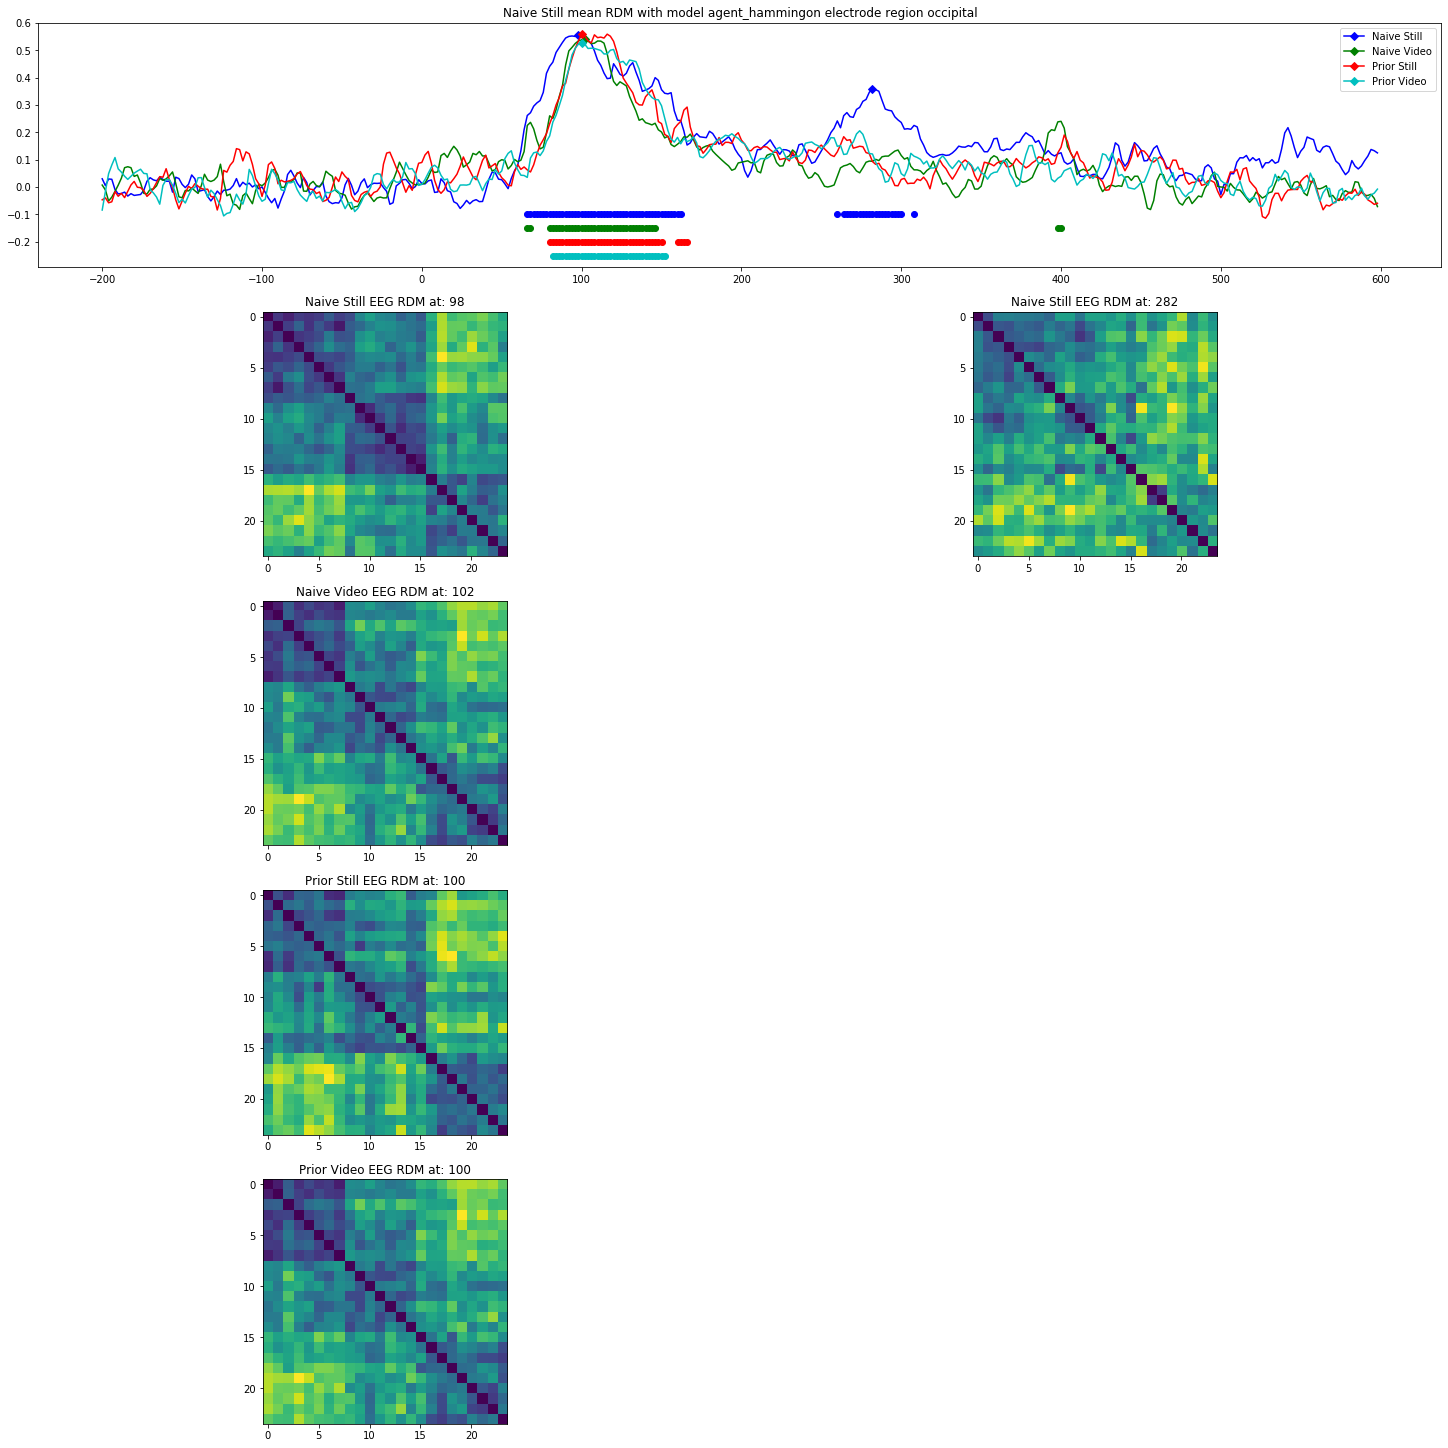

In [126]:

# Calculate Start index from start tie
fig = plt.figure(constrained_layout=True,figsize=(20,20))
gs = fig.add_gridspec(5, max(len(max_nv_time),len(max_ns_time),len(max_pv_time),len(max_pv_time)))
f_ax1 = fig.add_subplot(gs[0, :])
 
# Mark significcant points
f_ax1.scatter(pos_corr_n_s.time.values.tolist(),[-0.1]*len(pos_corr_n_s.time.values.tolist()),c="b")
f_ax1.scatter(pos_corr_n_v.time.values.tolist(),[-0.15]*len(pos_corr_n_v.time.values.tolist()),c="g")
f_ax1.scatter(pos_corr_p_s.time.values.tolist(),[-0.2]*len(pos_corr_p_s.time.values.tolist()),c="r")
f_ax1.scatter(pos_corr_p_v.time.values.tolist(),[-0.25]*len(pos_corr_p_v.time.values.tolist()),c="c")
f_ax1.plot(df_n_s.kendall_tau,'-bD',markevery=[int(x/2+100) for x in max_ns_time],label="Naive Still")
f_ax1.plot(df_n_v.kendall_tau,'-gD',markevery=[int(x/2+100) for x in max_nv_time], label="Naive Video")
f_ax1.plot(df_p_s.kendall_tau,'-rD',markevery=[int(x/2+100) for x in max_ps_time], label="Prior Still")
f_ax1.plot(df_p_v.kendall_tau,'-cD',markevery=[int(x/2+100) for x in max_pv_time], label="Prior Video")


f_ax1.set_title('Naive Still mean RDM with model ' + model + "on electrode region " + er)
f_ax1.legend()

for i,max_ns_start_time in enumerate(max_ns_time):
    ax = fig.add_subplot(gs[1, i])
    RDM_n_s = np.mean(windowed_eeg_rdm_dict_n_sff[(max_ns_start_time,max_ns_start_time+time_window)],0)
    ax.imshow(squareform(RDM_n_s))
    ax.set_title("Naive Still EEG RDM at: " + str(max_ns_start_time))
    
    
for i,max_nv_start_time in enumerate(max_nv_time):
    ax = fig.add_subplot(gs[2, i])
    RDM_n_v = np.mean(windowed_eeg_rdm_dict_n_v[(max_nv_start_time,max_nv_start_time+time_window)],0)
    ax.imshow(squareform(RDM_n_v))
    ax.set_title("Naive Video EEG RDM at: " + str(max_nv_start_time))
    
    
for i,max_ps_start_time in enumerate(max_ps_time):
    ax = fig.add_subplot(gs[3, i])
    RDM_p_s = np.mean(windowed_eeg_rdm_dict_p_s[(max_ps_start_time,max_ps_start_time+time_window)],0)
    ax.imshow(squareform(RDM_p_s))
    ax.set_title("Prior Still EEG RDM at: " + str(max_ps_start_time))
    
    
for i,max_pv_start_time in enumerate(max_pv_time):
    ax = fig.add_subplot(gs[4, i])
    RDM_p_v = np.mean(windowed_eeg_rdm_dict_p_v[(max_pv_start_time,max_pv_start_time+time_window)],0)
    ax.imshow(squareform(RDM_n_v))
    ax.set_title("Prior Video EEG RDM at: " + str(max_pv_start_time))

In [91]:
RDM_n_s = np.mean(windowed_eeg_rdm_dict_n_sff[(max_ns_start_time,max_ns_start_time+time_window)],0)



In [93]:
max_ns_start_time

282